In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import scipy.io as sio
import scipy.stats as stats

# 1. Convertimos los datos usando $\Delta_{ID}=1$

In [3]:
dir_path = 'masks/'
# add this path to the system path
sys.path.append(dir_path)

In [4]:
files = os.listdir(dir_path)

In [5]:
# create a dictionary of the masks
masks = {}

for file in files:
    name = file.split('_')[0]
    array = sio.loadmat(dir_path + file)['masks']
    n_steps = array.shape[-1]
    grid = np.zeros_like(array)
    grid[:, :, 0] = array[:, :, 0].copy()
    for i in range(1, n_steps):
        grid[:,:,i][grid[:,:,i-1]>=1] = 2
        grid[:,:,i][grid[:,:,i-1]==0] = array[:,:,i][grid[:,:,i-1]==0].copy()    
    masks[name] = grid.copy()


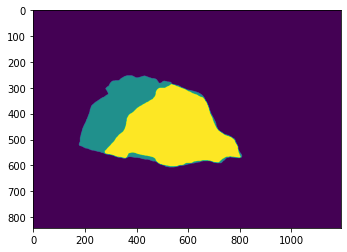

In [6]:
plt.imshow(masks['Artana'][:, :, 3])

# 2. Guardamos los datos en formato binario

In [7]:
import pickle
#with open('grid_data_dict/masks.pkl', 'wb') as f:
#    pickle.dump(masks, f)

In [8]:
masks = pickle.load(open('grid_data_dict/masks.pkl', 'rb'))

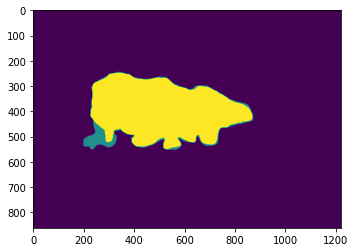

In [9]:
plt.imshow(masks['Beneixama'][:, :, -1])

# 3. Hacemos el CROP 

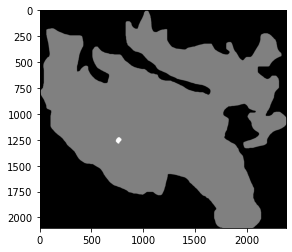

In [13]:
binary_mask = masks['Beniarda'][:, :, -1]
rows, cols = np.nonzero(binary_mask)
min_row, max_row = np.min(rows), np.max(rows)
min_col, max_col = np.min(cols), np.max(cols)
size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
size = np.max([size_1, size_2])
bbox = (min_row, min_col, max_row - min_row + 1, max_col - min_col + 1)
cropped_mask = binary_mask[min_row:max_row+1, min_col:max_col+1]
plt.imshow(cropped_mask, cmap='gray')
plt.savefig('cropped_mask_Beniarda.png')
plt.show()

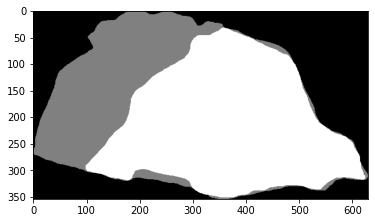

In [14]:
binary_mask = masks['Artana'][:, :, -1]
rows, cols = np.nonzero(binary_mask)
min_row, max_row = np.min(rows), np.max(rows)
min_col, max_col = np.min(cols), np.max(cols)
size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
size = np.max([size_1, size_2])
bbox = (min_row, min_col, max_row - min_row + 1, max_col - min_col + 1)
cropped_mask = binary_mask[min_row:max_row+1, min_col:max_col+1]
plt.imshow(cropped_mask, cmap='gray')
plt.savefig('cropped_mask_Artana.png')
plt.show()

In [15]:
def get_bounding_square(mask):
    rows, cols = np.nonzero(mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    size = np.max([size_1, size_2])
    return size

sizes = [get_bounding_square(masks[name][:,:,-1]) for name in masks.keys()]
size = np.max(sizes)
if size%2 == 1:
    size += 1
size

2378

In [16]:
masks_cropped = {}
def pad_mask(mask, size):
    rows, cols = np.nonzero(mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    row_padding = (size - size_1) // 2
    col_padding = (size - size_2) // 2
    padded_mask = np.zeros((size, size))
    padded_mask[row_padding:row_padding + size_1, col_padding:col_padding + size_2] = mask[min_row:max_row + 1, min_col:max_col + 1]
    return padded_mask

for name in masks.keys():
    z = masks[name].shape[-1]
    aux = np.zeros(shape=(size, size, z))
    for i in range(masks[name].shape[-1]):
        binary_mask = masks[name][:, :, i]
        padded_mask = pad_mask(binary_mask, size)
        aux[:,:, i] = padded_mask.copy()
    masks_cropped[name] = aux.copy()
    #binary_mask = masks[name][:, :, -1]
    #padded_mask = pad_mask(binary_mask, size)
    #plt.imshow(padded_mask, cmap='gray')
    #aux[name] = padded_mask.copy()

In [17]:
import cv2

In [18]:
masks_crop_resize = {}
resize = 64
for name in masks_cropped.keys():
    z = masks_cropped[name].shape[-1]
    aux = np.zeros(shape=(resize, resize, z))
    for i in range(masks_cropped[name].shape[-1]):
        binary_mask = masks_cropped[name][:, :, i]
        aux[:,:, i] = cv2.resize(binary_mask, (resize, resize), interpolation=cv2.INTER_NEAREST)
    masks_crop_resize[name] = aux.copy()

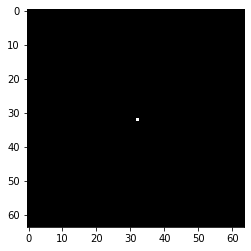

In [19]:
plt.imshow(masks_crop_resize['Carcaixent'][:, :, 0], cmap='gray')

In [20]:
for name in masks_crop_resize.keys():
    if np.sum(masks_crop_resize[name][:,:,0]) == 0:
        print(name)

In [21]:
for name in masks_crop_resize.keys():
    print(name, np.where(masks_crop_resize[name][:,:,0] == 1))

Artana (array([32], dtype=int64), array([32], dtype=int64))
Beneixama (array([32], dtype=int64), array([32], dtype=int64))
Beniarda (array([32], dtype=int64), array([32], dtype=int64))
Bolulla (array([32], dtype=int64), array([32], dtype=int64))
Carcaixent (array([32], dtype=int64), array([32], dtype=int64))
Chella (array([32], dtype=int64), array([32], dtype=int64))
Gatova (array([32], dtype=int64), array([32], dtype=int64))
Llutxent (array([32], dtype=int64), array([32], dtype=int64))
Montan (array([32], dtype=int64), array([32], dtype=int64))
ValldEbo (array([32], dtype=int64), array([32], dtype=int64))
VallGallinera (array([32], dtype=int64), array([32], dtype=int64))


In [22]:
#with open('grid_data_dict/masks_scaled.pkl', 'wb') as f:
#    pickle.dump(masks_crop_resize, f)

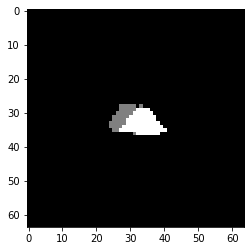

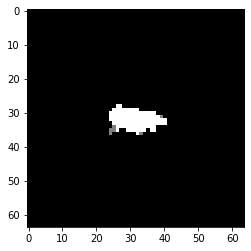

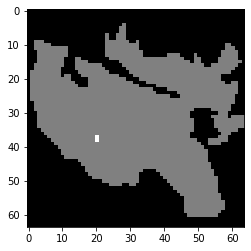

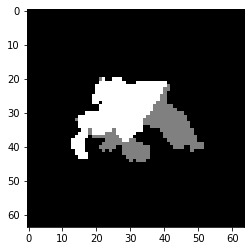

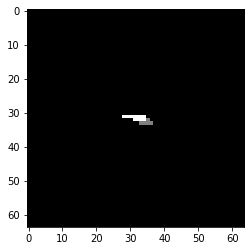

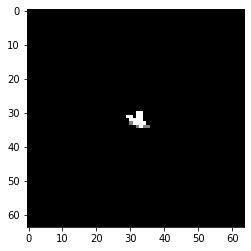

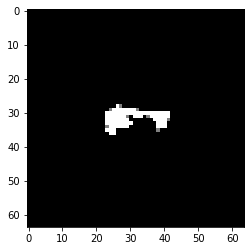

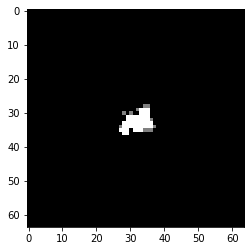

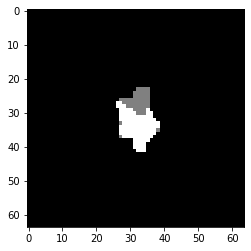

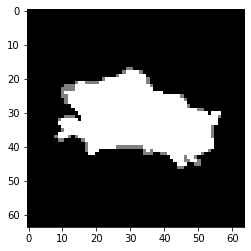

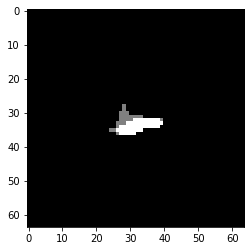

In [23]:
for name in masks_crop_resize.keys():
    plt.imshow(masks_crop_resize[name][:,:,-1], cmap='gray')
    plt.show()

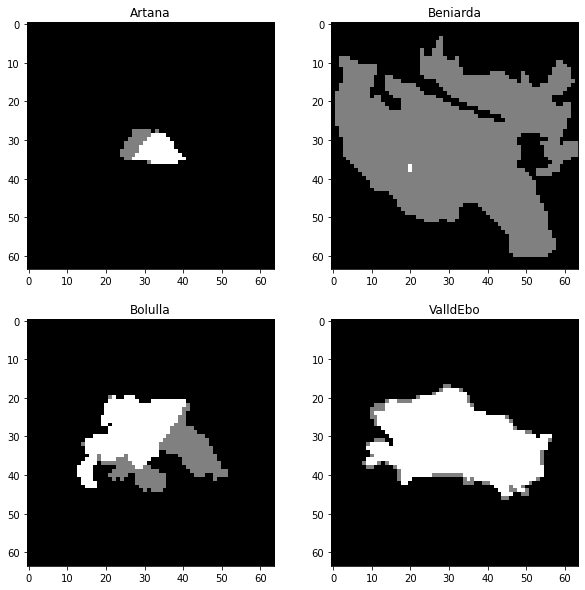

In [33]:
# Lista con los nombres que deseas visualizar
names_to_show = ["Artana", "Beniarda", "Bolulla", "ValldEbo"]

# Crear una figura con subplots divididos en 4 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Recorrer los subplots y agregar la imagen correspondiente
for i, ax in enumerate(axs.ravel()):
    if i < len(names_to_show):
        name = names_to_show[i]
        ax.imshow(masks_crop_resize[name][:, :, -1], cmap='gray')
        ax.set_title(name)

# Mostrar la figura
plt.savefig('Figures/masks_crop_resize.png')
plt.show()


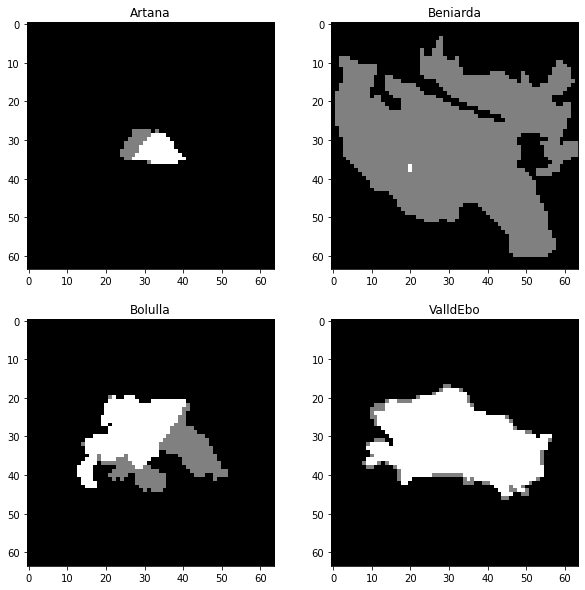

In [32]:
fig

In [24]:
#with open('grid_data_dict/masks_scaled.pkl', 'wb') as f:
#    pickle.dump(masks_crop_resize, f)